In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

### Model Equations:
Correct: a * b * c * d * e * f

Semantic: a * b * (1 - c) * f

Formal: a * b * c * (1 - d) * f + a * b * c * (1 - d) * (1 - f) * g + a * b * c * d * (1 - e) * (1 - f) * g + a * b * c * d * e * (1 - f) * g

Mixed: a * b * c * d * (1 - e) * f

Unrelated: a * (1 - b) * f + a * (1 - b) * (1 - f) * h + a * b * (1 - c) * (1 - f) * h

Neologism: a * b * c * (1 - d) * (1 - f) * (1 - g) + a * b * c * d * (1 - e) * (1 - f) * (1 - g) + a * b * c * d * e * (1 - f) * (1 - g)

Abstruse Neologism: a * (1 - b) * (1 - f) * (1 - h) + a * b * (1 - c) * (1 - f) * (1 - h)

Nonnaming Attempt: 1 - a

### Data Simulation (Bonus):

In [3]:
# Fix true parameters
a = 0.95
b = 0.8
c = 0.75
d = 0.65
e = 0.7
f = 0.9
g = 0.4
h = 0.2

# Fix true probabilities and simulate from model
num_trials = 120
true_probs = {
    'correct': a * b * c * d * e * f,
    'semantic': a * b * (1 - c) * f,
    'formal': a * b * c * (1 - d) * f + a * b * c * (1 - d) * (1 - f) * g + a * b * c * d * (1 - e) * (1 - f) * g + a * b * c * d * e * (1 - f) * g,
    'mixed': a * b * c * d * (1 - e) * f,
    'unrelated': a * (1 - b) * f + a * (1 - b) * (1 - f) * h + a * b * (1 - c) * (1 - f) * h,
    'neologism': a * b * c * (1 - d) * (1 - f) * (1 - g) + a * b * c * d * (1 - e) * (1 - f) * (1 - g) + a * b * c * d * e * (1 - f) * (1 - g),
    'abstruse neologism': a * (1 - b) * (1 - f) * (1 - h) + a * b * (1 - c) * (1 - f) * (1 - h),
    'nonnaming attempt': 1 - a
}

global_rng = np.random.default_rng(42)
data = global_rng.multinomial(n=num_trials, pvals=list(true_probs.values()))
pd.DataFrame(data[:, None].T, columns=true_probs.keys(), index=['responses'])

,correct,semantic,formal,mixed,unrelated,neologism,abstruse neologism,nonnaming attempt
responses,31,19,28,12,22,5,2,1


In [4]:
mpt_model_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower=0, upper=1> a;
  real<lower=0, upper=1> b;
  real<lower=0, upper=1> c;
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> e;
  real<lower=0, upper=1> f;
  real<lower=0, upper=1> g;
  real<lower=0, upper=1> h;
}

transformed parameters {
  simplex[K] theta;
  theta[1] = a * b * c * d * e * f; // Prob. Correct
  theta[2] = a * b * (1 - c) * f; // Prob. Semantic
  theta[3] = a * b * c * (1 - d) * f + a * b * c * (1 - d) * (1 - f) * g + a * b * c * d * (1 - e) * (1 - f) * g + a * b * c * d * e * (1 - f) * g; // Prob. Formal
  theta[4] = a * b * c * d * (1 - e) * f; // Prob. Mixed
  theta[5] = a * (1 - b) * f + a * (1 - b) * (1 - f) * h + a * b * (1 - c) * (1 - f) * h; // Prob. Unrelated
  theta[6] = a * b * c * (1 - d) * (1 - f) * (1 - g) + a * b * c * d * (1 - e) * (1 - f) * (1 - g) + a * b * c * d * e * (1 - f) * (1 - g); // Prob. Neologism
  theta[7] = a * (1 - b) * (1 - f) * (1 - h) + a * b * (1 - c) * (1 - f) * (1 - h); // Prob. Abstruse Neologism
  theta[8] = 1 - a; // Prob. Nonnaming Attempt
}

model {
  //Prior
  target += beta_lpdf(a | 1, 1);
  target += beta_lpdf(b | 1, 1);
  target += beta_lpdf(c | 1, 1);
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(e | 1, 1);
  target += beta_lpdf(f | 1, 1);
  target += beta_lpdf(g | 1, 1);
  target += beta_lpdf(h | 1, 1);

  //Likelihood
  target += multinomial_lpmf(freqs | theta);
}

generated quantities{
  // Predictions of frequencies go here
  array[K] int preds = multinomial_rng(theta, N);
}
"""

In [5]:
# Prepare data
stan_dict = {
    'freqs': data,
    'N': num_trials,
    'K': data.shape[0]
}

# Compile model
posterior = stan.build(mpt_model_code, data=stan_dict, random_seed=42)

# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 6.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!


In [9]:
# Parameter recovery and predictions
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.984,0.012,0.963,1.000,0.000,0.000,7831.0,4623.0,1.0
b,0.829,0.048,0.736,0.920,0.001,0.001,4007.0,2572.0,1.0
c,0.761,0.051,0.666,0.852,0.001,0.001,4753.0,4459.0,1.0
d,0.691,0.108,0.515,0.924,0.002,0.002,2918.0,2688.0,1.0
e,0.710,0.067,0.589,0.836,0.001,0.000,9689.0,6891.0,1.0
f,0.822,0.104,0.611,0.961,0.002,0.002,2524.0,3140.0,1.0
g,0.512,0.243,0.056,0.878,0.004,0.003,3191.0,5339.0,1.0
h,0.589,0.246,0.121,0.957,0.004,0.003,3885.0,4323.0,1.0
theta[0],0.246,0.038,0.177,0.319,0.000,0.000,10701.0,8766.0,1.0
theta[1],0.158,0.032,0.101,0.219,0.000,0.000,10648.0,7503.0,1.0


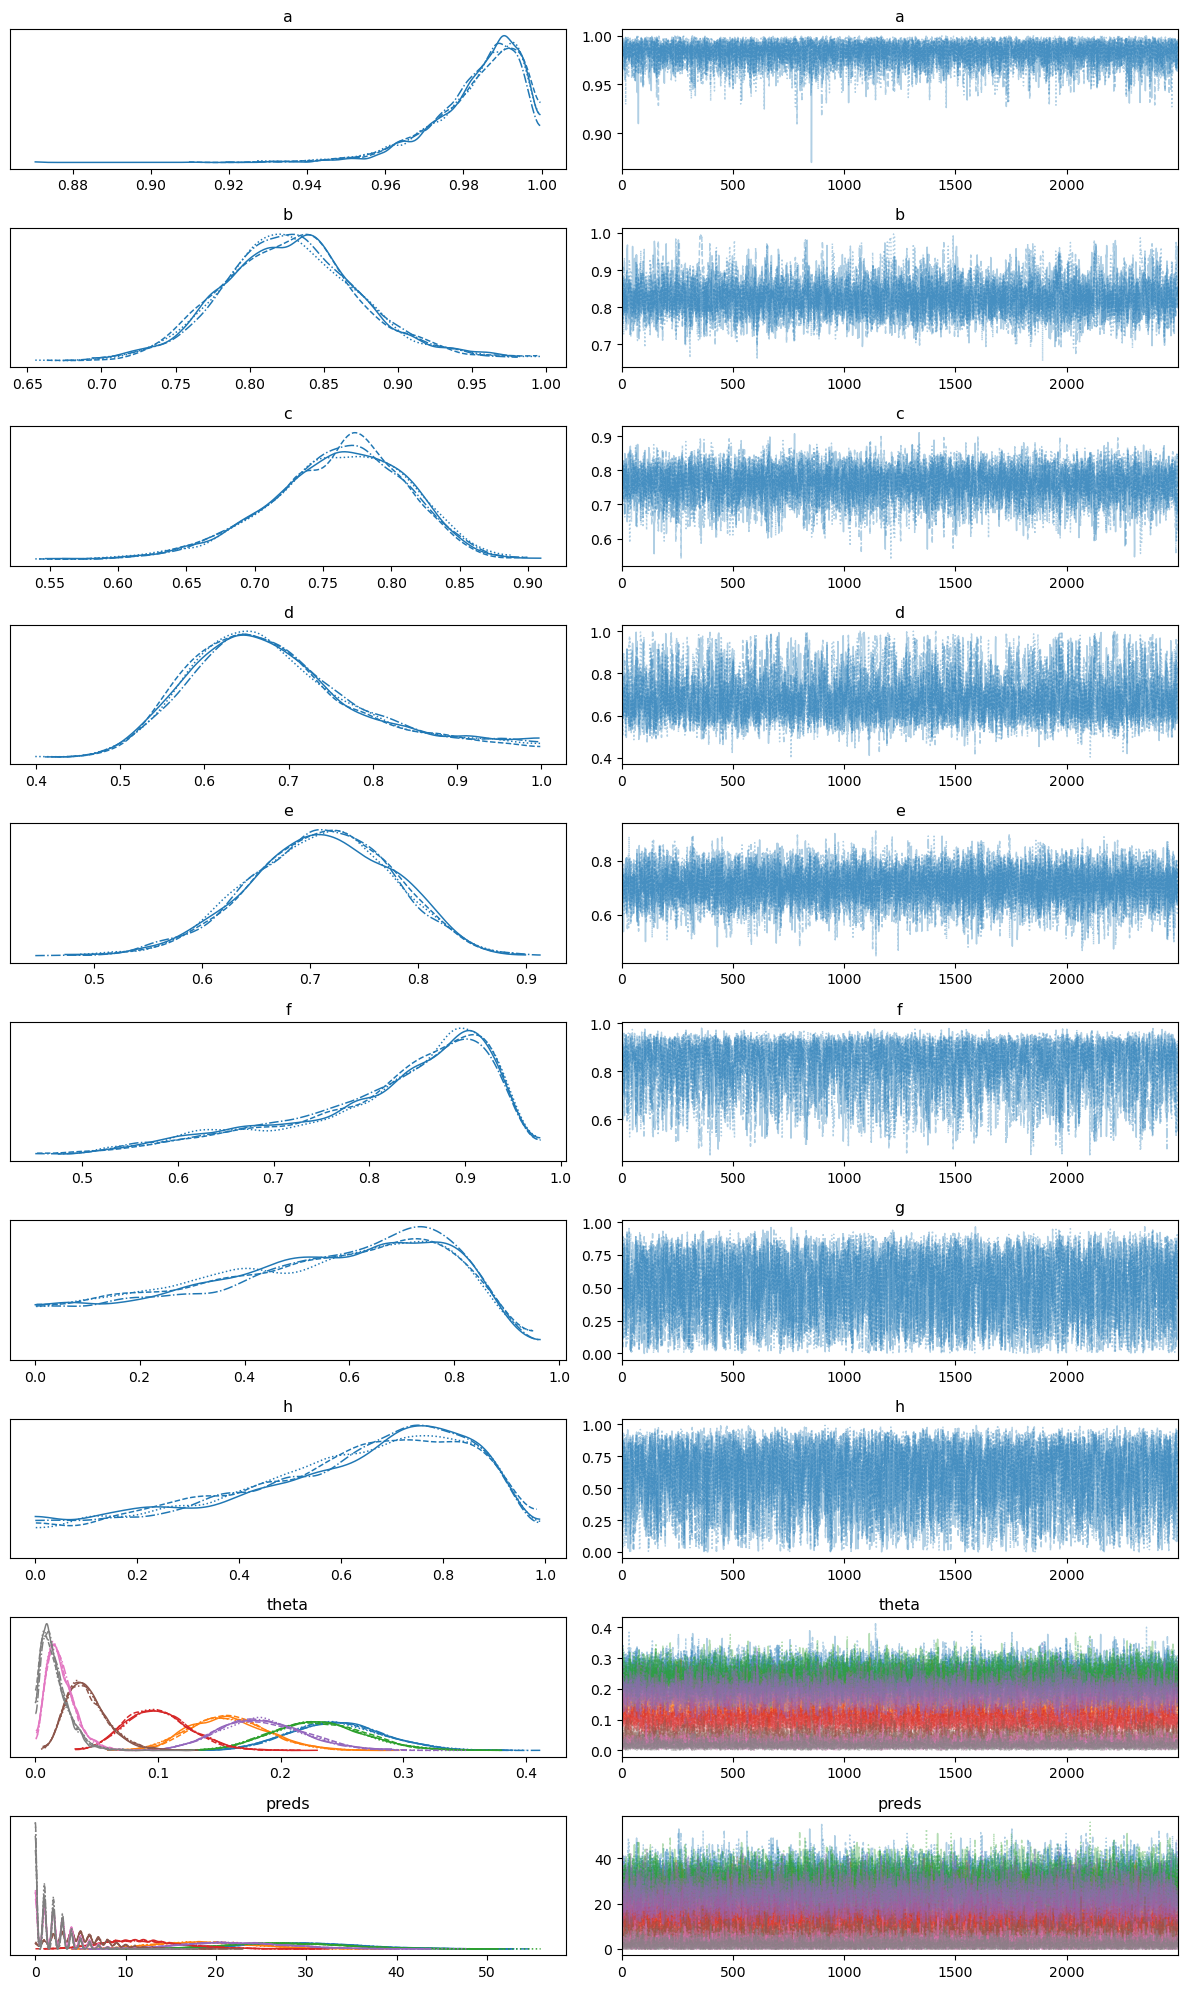

In [10]:
# Traceplots and marginals - visual convergence checks
axarr = az.plot_trace(fit)
plt.tight_layout()

### Results:
We see that the model converges because r_hat is 1.0 and it is efficient because the efficiency diagnostic (ess) is usually less than 10000 (num_samples * num_chains).

##### Parameter Recovery:
| Parameter | Predicted | Actual |
|-----------|-----------|--------|
| a         | 0.984     | 0.95   |
| b         | 0.829     | 0.8    |
| c         | 0.761     | 0.75   |
| d         | 0.691     | 0.65   |
| e         | 0.710     | 0.7    |
| f         | 0.822     | 0.9    |
| g         | 0.512     | 0.4    |
| h         | 0.589     | 0.2    |

We see that a, b, c, d, and e were estimated accurately, f and g were estimated pretty accurately, and h wasn't estimated accurately. However, all the parameters still fall within the acceptable highest density interval, so overall the model is accurate for parameter recovery.

##### Data Prediction:
| Response           | Predicted | Actual |
|--------------------|-----------|--------|
| Correct            | 29.444    | 31     |
| Semantic           | 18.959    | 19     |
| Formal             | 27.701    | 28     |
| Mixed              | 12.056    | 12     |
| Unrelated          | 22.175    | 22     |
| Neologism          | 5.179     | 5      |
| Abstruse Neologism | 2.532     | 2      |
| Nonnaming Attempt  | 1.954     | 1      |

We see that the model predicts the true data accurately. It makes sense that the model is accurate because the number of parameters is equivalent to the number of responses.